# Import dependencies

In [81]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
from adbrew_core.settings import db
from adbrew_core.db import accessor
from adbrew_core.utils import conversion_rates
from adbrew_core.rule_engine import rule_engine_variables
from adbrew_core.db import bid_management_task

In [4]:
accounts = {}
unique_adgs = []

idx = 0
total_accounts = 300

for account in db.account_details.find({"active":True, "fetch_data":True}):
    
    record = db.report_records.aggregate([
        {
            "$match": {
                "account_id": str(account["_id"]),
                "dt": {
                    "$gte": datetime.datetime.now() - datetime.timedelta(days=45),
                    "$lte": datetime.datetime.now()
                },
                "record_type":"keywords",
                "segment":None,
                "campaign_type":"sp"
            }
        },
        {
            "$group": {
                "_id": {
                    "accountId":"$account_id",
                    "adGroupId":"$adGroupId",
                    "campaignId":"$campaignId",
                }
            }
        }
    ], allowDiskUse=True)
    record = pd.DataFrame(record)
    if record.empty:
        continue
    record["accountId"] = record.apply(lambda x:x["_id"]["accountId"], axis=1)
    record["campaignId"] = record.apply(lambda x:x["_id"]["campaignId"], axis=1)
    record["adGroupId"] = record.apply(lambda x:x["_id"]["adGroupId"], axis=1)
    record.drop(columns=["_id"], inplace=True)
    if record.empty:
        continue
    unique_adgs += [record]
    print(idx, end='\r', flush=True)
    idx+=1
    if idx==total_accounts:
        break
    
unique_adgs = pd.concat(unique_adgs)
for idx in range(len(unique_adgs)):
    record = unique_adgs.iloc[idx:idx+1].reset_index(drop=True)
    account_id = record["accountId"][0]
    campaign_id = record["campaignId"][0]
    adgroup_id = record["adGroupId"][0]
    if account_id not in accounts:
        accounts[account_id] = {campaign_id:[adgroup_id]}
    elif campaign_id not in accounts[account_id]:
        accounts[account_id][campaign_id] = [adgroup_id]
    else:
        accounts[account_id][campaign_id] += [adgroup_id]

# import pprint
# pprint.pprint(accounts)

In [43]:
df = pd.read_csv("df_days_active.csv")

In [44]:
list1  = df[df['no_of_days']>329]['Id']

In [45]:
a = list(list1)

In [46]:
len(a)

21

In [47]:
dic = {}
for i in a:
    dic[i] = accounts[i]

In [48]:
accounts = dic

In [35]:
only_asin_ppc=True 
threshold=30
cvr_threshold=40
use_lookback_dict=False
lookback_dict=None

In [50]:
ssc_calc_lookback = 180
campaign_type = "sp"

adgroup_ssc = {}
adgroup_source = {}

class Context:
    def __init__(self, overall_cr):
        self.overall_cr = overall_cr

idx = 0
cr_sources = {}

for account, campaigns in accounts.items():
    for campaign, adgroups in campaigns.items():
        for adgroup in adgroups:

            # 1. get 14 day data of keywords and targets

            keyword_data = accessor.get_targeting_report(account, campaign, adgroup, 45, campaign_type, "keywords")
            # targets_data = accessor.get_targeting_report(account, campaign, adgroup, lookback_days, campaign_type, "targets")
            if keyword_data["clicks"].sum() == 0:
                idx += 1
                continue
            keyword_data = keyword_data.loc[keyword_data["clicks"]>0]

            # 2. Calculate SSC of adgroup
            # 2.1 Get Products in Adgroup

            task = bid_management_task.BidManagementTask.from_attributes(account, 0, campaign, adgroup, "sp", 0, True)
            asins = task.get_adv_asins()

            # 2.2 Get CR for ADG

            overall_cr, cr_source = conversion_rates.get_overall_conversion_rate_for_asins_daywise(account, asins, ssc_calc_lookback, threshold, cvr_threshold)
            if overall_cr is None:
                idx += 1
                continue
            overall_cr/=100.0

            if only_asin_ppc:
                if cr_source != "ASIN_PPC":
                    continue

            if cr_source not in cr_sources:
                cr_sources[cr_source] = 1
            else:
                cr_sources[cr_source] += 1

            # 2.3 Get SSC for ADG

            REVC = rule_engine_variables.RuleEngineVariableComputer()
            context = Context(overall_cr)
            account = str(account)
            campaign = str(campaign)
            adgroup = str(adgroup)
            adgroups_ssc_adg = REVC.statistically_significant_clicks(context, keyword_data)

            if account not in adgroup_ssc:
                adgroup_ssc[account] = {campaign:{adgroup:adgroups_ssc_adg}}
                adgroup_source[account] = {campaign:{adgroup:cr_source}}
            elif campaign not in adgroup_ssc:
                adgroup_ssc[account][campaign] = {adgroup:adgroups_ssc_adg}
                adgroup_source[account][campaign] = {adgroup:cr_source}
            elif adgroup not in adgroup_ssc:
                adgroup_ssc[account][campaign][adgroup] = adgroups_ssc_adg
                adgroup_source[account][campaign][adgroup] = cr_source


import json
with open("ssc_180_accounts.json", "w") as outfile:
    json.dump(adgroup_ssc, outfile)

with open("cr_sources_180_accounts.json", "w") as outfile:
    json.dump(adgroup_source, outfile)

cr_sources_df = pd.DataFrame(columns=["source", "count"])
for source, count in cr_sources.items():
    cr_sources_df.loc[len(cr_sources_df)] = [source, count]


In [146]:
import json
load = open("ssc_365_accounts.json")
ssc_365 = json.load(load)

In [147]:
load = open("ssc_180_accounts.json")
ssc_180 = json.load(load)

In [148]:
load = open("ssc_90_accounts.json")
ssc_90 = json.load(load)

In [149]:
df = pd.DataFrame(columns = ["account_id","adgroup_id","365_days","180_days","90_days"])

In [150]:
for i,j in ssc_365.items():
    for k,l in j.items():
        for m in l:
            try:
                if ssc_365[i][k][m] and ssc_180[i][k][m] and ssc_90[i][k][m]:
                    df.loc[len(df)] = [i,m,ssc_365[i][k][m] , ssc_180[i][k][m] , ssc_90[i][k][m]]
            except:pass

In [151]:
df

,account_id,adgroup_id,365_days,180_days,90_days
0,5ffdb895b08512986422b08c,144980610686053,14,11,11
1,5ffdb895b08512986422b08c,60175740392859,13,15,17
2,5ffdb895b08512986422b08c,96484107418934,13,12,12
3,5ffdb895b08512986422b08c,256692167766571,8,6,4
4,5ffdb895b08512986422b08c,126012498669947,35,34,32
...,...,...,...,...,...
545,623dda6df77df1d4d204dfc9,84078237083028,28,15,11
546,6261426cc1024ef2d95110c3,255196315299560,11,11,11
547,6261426cc1024ef2d95110c3,111866482309718,35,36,33
548,6263acc5367e283277f9a0ef,255196315299560,11,11,11


In [73]:
# No of adgroup having greater 365_days_cr  ssc values than 90_days_cr ssc values
df[df["365_days"]>df['90_days']]
print(len(df[df["365_days"]>df['90_days']]))

278


In [74]:
# No of adgroup having greater 365_days_cr  ssc values than 180_days_cr ssc values
df[df["365_days"]>df['180_days']]
print(len(df[df["365_days"]>df['180_days']]))

235


In [75]:
# No of adgroup having greater 180_days_cr  ssc values than 90_days_cr ssc values
df[df["180_days"]>df['90_days']]
print(len(df[df["180_days"]>df['90_days']]))

252


In [76]:
# No of adgroup having less 180_days_cr  ssc values than 90_days_cr ssc values
df[df["180_days"]<df['90_days']]
print(len(df[df["180_days"]<df['90_days']]))

183


In [77]:
# No of adgroup having less 365_days_cr  ssc values than 180_days_cr ssc values
df[df["365_days"]<df['180_days']]
print(len(df[df["365_days"]<df['180_days']]))

153


In [78]:
# No of adgroup having less 365_days_cr  ssc values than 90_days_cr ssc values
df[df["365_days"]<df['90_days']]
print(len(df[df["365_days"]<df['90_days']]))

177


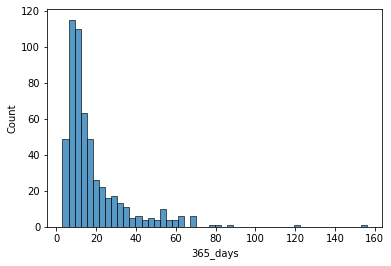

In [82]:
sns.histplot(df['365_days'])
plt.show()

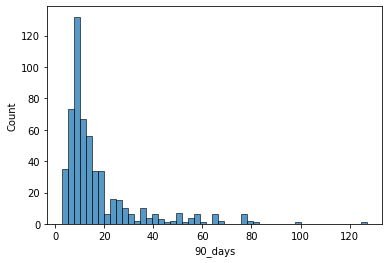

In [93]:
sns.histplot(df['90_days'])
plt.show()

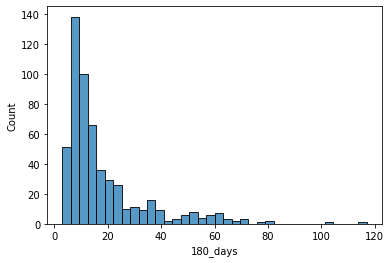

In [92]:
sns.histplot(df['180_days'])
plt.show()

## SSC difference for 365_days and 90 Days  -Means 365 minus 90

In [282]:
df_diff = pd.DataFrame(columns = ['diff_365_90'])

In [283]:
for i,j in ssc_365.items():
    for k,l in j.items():
        for m in l:
            try:
                if ssc_365[i][k][m] and ssc_90[i][k][m]:
                    df_diff.loc[len(df_diff)] = [ssc_365[i][k][m]-ssc_90[i][k][m]]
            except:pass

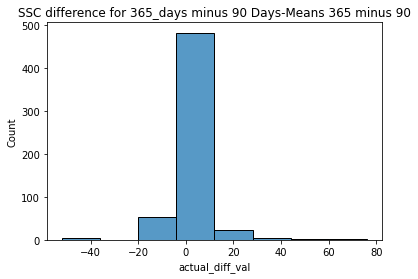

In [284]:
sns.histplot(df_diff["diff_365_90"],bins = 8)
plt.title("SSC difference for 365_days minus 90 Days-Means 365 minus 90")
plt.xlabel("actual_diff_val")
plt.show()

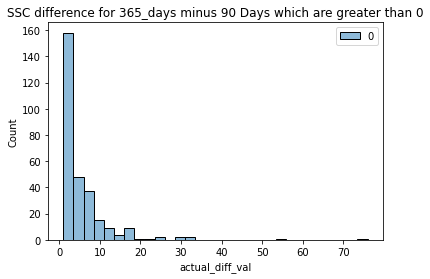

In [285]:
sns.histplot(df_diff[df_diff['diff_365_90']>0].values,bins = 30)
plt.title("SSC difference for 365_days minus 90 Days which are greater than 0")
plt.xlabel("actual_diff_val")
plt.show()

In [286]:
ssc_diff_greater_than_10 = np.array(df_diff[df_diff['diff_365_90']>10].values)
len(ssc_diff_greater_than_10)

32

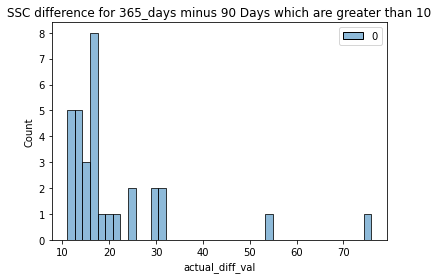

In [193]:
sns.histplot(ssc_diff_greater_than_10,bins = 40)
plt.title("SSC difference for 365_days minus 90 Days which are greater than 10")
plt.xlabel("actual_diff_val")
plt.show()

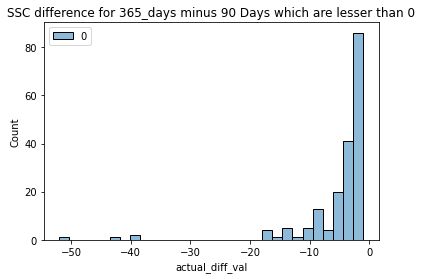

In [194]:
sns.histplot(df_diff[df_diff['diff_365_90']<0].values,bins = 30)
plt.title("SSC difference for 365_days minus 90 Days which are lesser than 0")
plt.xlabel("actual_diff_val")
plt.show()

# SSC difference for 365_days and 180 Days   - means 365 minus 180

In [206]:
df_diff = pd.DataFrame(columns = ['diff_365_180'])

In [207]:
for i,j in ssc_365.items():
    for k,l in j.items():
        for m in l:
            try:
                if ssc_365[i][k][m] and ssc_180[i][k][m]:
                    df_diff.loc[len(df_diff)] = [ssc_365[i][k][m]-ssc_180[i][k][m]]
            except:pass

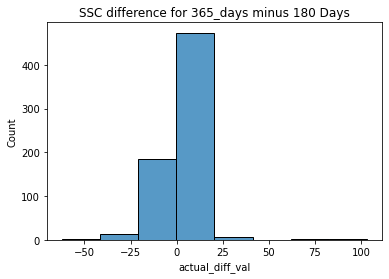

In [208]:
sns.histplot(df_diff["diff_365_180"],bins = 8)
plt.title("SSC difference for 365_days minus 180 Days")
plt.xlabel("actual_diff_val")
plt.show()

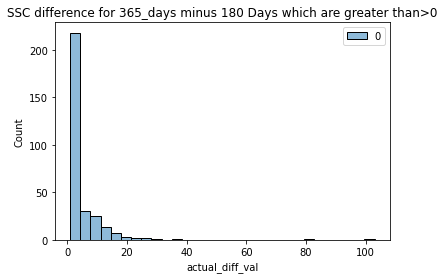

In [209]:
sns.histplot(df_diff[df_diff['diff_365_180']>0].values,bins = 30)
plt.title("SSC difference for 365_days minus 180 Days which are greater than>0")
plt.xlabel("actual_diff_val")
plt.show()

In [210]:
ssc_diff_greater_than_10 = np.array(df_diff[df_diff['diff_365_180']>10].values)
len(ssc_diff_greater_than_10)

35

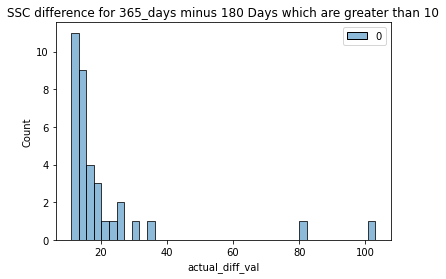

In [212]:
sns.histplot(ssc_diff_greater_than_10,bins = 40)
plt.title("SSC difference for 365_days minus 180 Days which are greater than 10")
plt.xlabel("actual_diff_val")
plt.show()

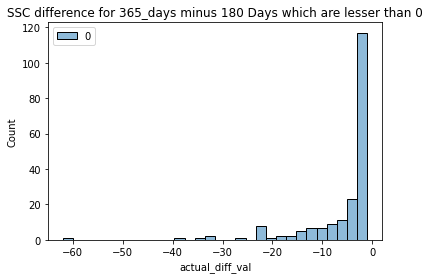

In [213]:
sns.histplot(df_diff[df_diff['diff_365_180']<0].values,bins = 30)
plt.title("SSC difference for 365_days minus 180 Days which are lesser than 0")
plt.xlabel("actual_diff_val")
plt.show()

# SSC difference for 180_days and 90 Days    -  means 180 minus 90

In [287]:
df_diff = pd.DataFrame(columns = ['diff_180_90'])

In [288]:
for i,j in ssc_180.items():
    for k,l in j.items():
        for m in l:
            try:
                if ssc_180[i][k][m] and ssc_90[i][k][m]:
                    df_diff.loc[len(df_diff)] = [ssc_180[i][k][m]-ssc_90[i][k][m]]
            except:pass

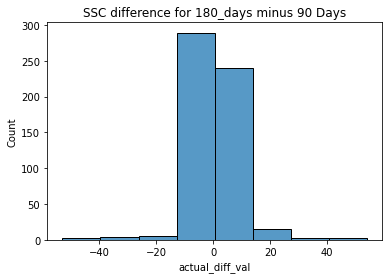

In [289]:
sns.histplot(df_diff["diff_180_90"],bins = 8)
plt.title("SSC difference for 180_days minus 90 Days")
plt.xlabel("actual_diff_val")
plt.show()

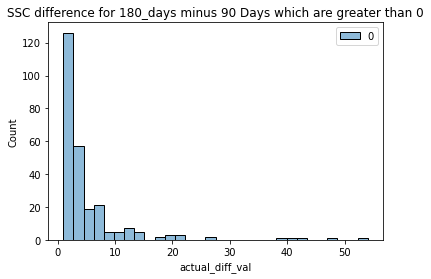

In [290]:
sns.histplot(df_diff[df_diff['diff_180_90']>0].values,bins = 30)
plt.title("SSC difference for 180_days minus 90 Days which are greater than 0")
plt.xlabel("actual_diff_val")
plt.show()

In [291]:
ssc_diff_greater_than_10 = np.array(df_diff[df_diff['diff_180_90']>10].values)
len(ssc_diff_greater_than_10)

30

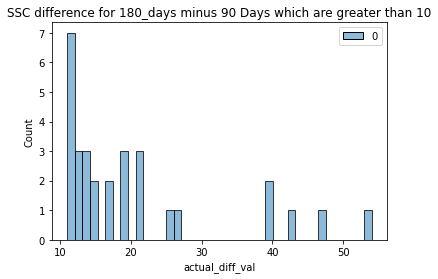

In [292]:
sns.histplot(ssc_diff_greater_than_10,bins = 40)
plt.title("SSC difference for 180_days minus 90 Days which are greater than 10")
plt.xlabel("actual_diff_val")
plt.show()

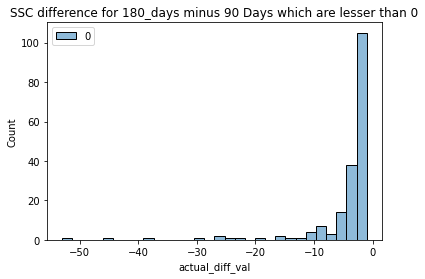

In [234]:
sns.histplot(df_diff[df_diff['diff_180_90']<0].values,bins = 30)
plt.title("SSC difference for 180_days minus 90 Days which are lesser than 0")
plt.xlabel("actual_diff_val")
plt.show()

# SSC difference for 90_days and 365 Days    -  means 90 minus 365

In [293]:
df_diff = pd.DataFrame(columns = ['diff_90_365'])

In [294]:
for i,j in ssc_365.items():
    for k,l in j.items():
        for m in l:
            try:
                if ssc_365[i][k][m] and ssc_90[i][k][m]:
                    df_diff.loc[len(df_diff)] = [ssc_90[i][k][m]-ssc_365[i][k][m]]
            except:pass

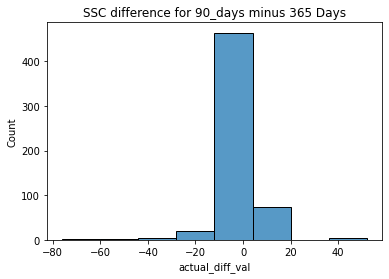

In [295]:
sns.histplot(df_diff["diff_90_365"],bins = 8)
plt.title("SSC difference for 90_days minus 365 Days")
plt.xlabel("actual_diff_val")
plt.show()

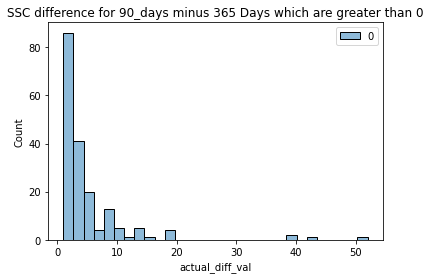

In [296]:
sns.histplot(df_diff[df_diff['diff_90_365']>0].values,bins = 30)
plt.title("SSC difference for 90_days minus 365 Days which are greater than 0")
plt.xlabel("actual_diff_val")
plt.show()

In [297]:
ssc_diff_greater_than_10 = np.array(df_diff[df_diff['diff_90_365']>10].values)
len(ssc_diff_greater_than_10)

17

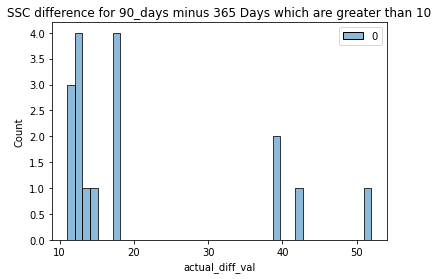

In [242]:
sns.histplot(ssc_diff_greater_than_10,bins = 40)
plt.title("SSC difference for 90_days minus 365 Days which are greater than 10")
plt.xlabel("actual_diff_val")
plt.show()

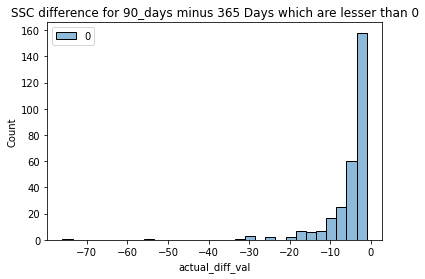

In [243]:
sns.histplot(df_diff[df_diff['diff_90_365']<0].values,bins = 30)
plt.title("SSC difference for 90_days minus 365 Days which are lesser than 0")
plt.xlabel("actual_diff_val")
plt.show()

# SSC difference for 90_days and 180 Days    -  means 90 minus 180

In [303]:
df_diff = pd.DataFrame(columns = ['diff_90_180'])

In [304]:
for i,j in ssc_90.items():
    for k,l in j.items():
        for m in l:
            try:
                if ssc_180[i][k][m] and ssc_90[i][k][m]:
                    df_diff.loc[len(df_diff)] = [ssc_90[i][k][m]-ssc_180[i][k][m]]
            except:pass

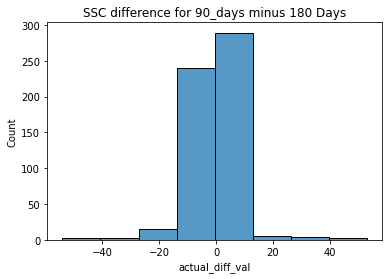

In [305]:
sns.histplot(df_diff["diff_90_180"],bins = 8)
plt.title("SSC difference for 90_days minus 180 Days")
plt.xlabel("actual_diff_val")
plt.show()

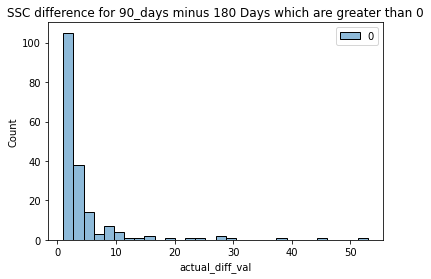

In [306]:
sns.histplot(df_diff[df_diff['diff_90_180']>0].values,bins = 30)
plt.title("SSC difference for 90_days minus 180 Days which are greater than 0")
plt.xlabel("actual_diff_val")
plt.show()

In [309]:
ssc_diff_greater_than_10 = np.array(df_diff[df_diff['diff_90_180']>10].values)
len(ssc_diff_greater_than_10)

14

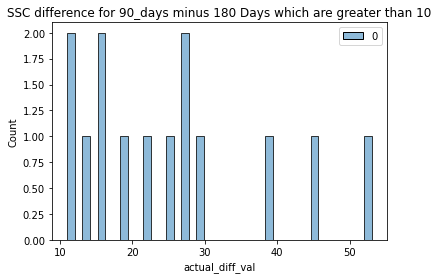

In [310]:
sns.histplot(ssc_diff_greater_than_10,bins = 40)
plt.title("SSC difference for 90_days minus 180 Days which are greater than 10")
plt.xlabel("actual_diff_val")
plt.show()

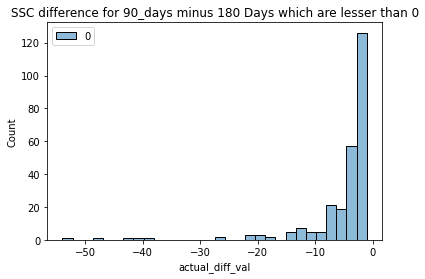

In [311]:
sns.histplot(df_diff[df_diff['diff_90_180']<0].values,bins = 30)
plt.title("SSC difference for 90_days minus 180 Days which are lesser than 0")
plt.xlabel("actual_diff_val")
plt.show()

# SSC difference for 180_days and 365 Days    -  means 180 minus 365

In [312]:
df_diff = pd.DataFrame(columns = ['diff_180_365'])

In [313]:
for i,j in ssc_180.items():
    for k,l in j.items():
        for m in l:
            try:
                if ssc_180[i][k][m] and ssc_365[i][k][m]:
                    df_diff.loc[len(df_diff)] = [ssc_180[i][k][m]-ssc_365[i][k][m]]
            except:pass

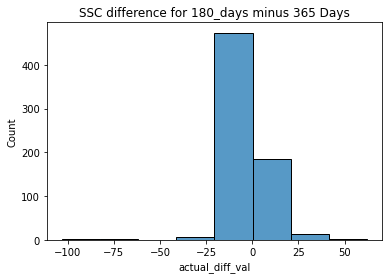

In [314]:
sns.histplot(df_diff["diff_180_365"],bins = 8)
plt.title("SSC difference for 180_days minus 365 Days")
plt.xlabel("actual_diff_val")
plt.show()

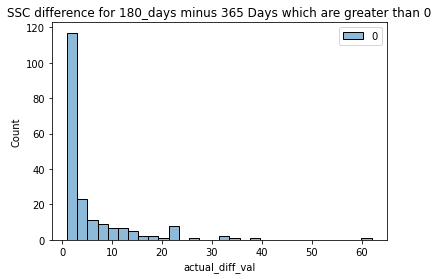

In [315]:
sns.histplot(df_diff[df_diff['diff_180_365']>0].values,bins = 30)
plt.title("SSC difference for 180_days minus 365 Days which are greater than 0")
plt.xlabel("actual_diff_val")
plt.show()

In [318]:
ssc_diff_greater_than_10 = np.array(df_diff[df_diff['diff_180_365']>10].values)
len(ssc_diff_greater_than_10)

34

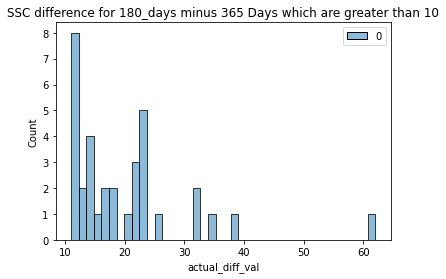

In [319]:
sns.histplot(ssc_diff_greater_than_10,bins = 40)
plt.title("SSC difference for 180_days minus 365 Days which are greater than 10")
plt.xlabel("actual_diff_val")
plt.show()

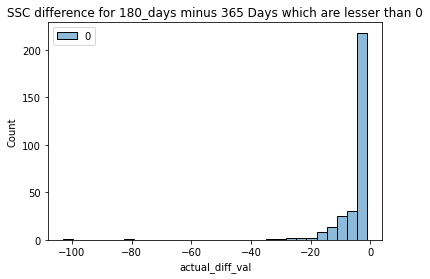

In [320]:
sns.histplot(df_diff[df_diff['diff_180_365']<0].values,bins = 30)
plt.title("SSC difference for 180_days minus 365 Days which are lesser than 0")
plt.xlabel("actual_diff_val")
plt.show()

In [321]:
df["365_90"] = df["365_days"] - df["90_days"]
df['365_180'] = df["365_days"]- df["180_days"]
df["180_90"] = df["180_days"] - df["90_days"]

In [154]:
df

,account_id,adgroup_id,365_days,180_days,90_days,365_90,365_180,180_90
0,5ffdb895b08512986422b08c,144980610686053,14,11,11,3,3,0
1,5ffdb895b08512986422b08c,60175740392859,13,15,17,-4,-2,-2
2,5ffdb895b08512986422b08c,96484107418934,13,12,12,1,1,0
3,5ffdb895b08512986422b08c,256692167766571,8,6,4,4,2,2
4,5ffdb895b08512986422b08c,126012498669947,35,34,32,3,1,2
...,...,...,...,...,...,...,...,...
545,623dda6df77df1d4d204dfc9,84078237083028,28,15,11,17,13,4
546,6261426cc1024ef2d95110c3,255196315299560,11,11,11,0,0,0
547,6261426cc1024ef2d95110c3,111866482309718,35,36,33,2,-1,3
548,6263acc5367e283277f9a0ef,255196315299560,11,11,11,0,0,0


In [158]:
len(df[df['365_90']==0])

95

In [159]:
len(df[df['365_180']==0])

162

In [160]:
len(df[df['180_90']==0])

115

In [163]:
df[df['365_90']>-1]

,account_id,adgroup_id,365_days,180_days,90_days,365_90,365_180,180_90
0,5ffdb895b08512986422b08c,144980610686053,14,11,11,3,3,0
2,5ffdb895b08512986422b08c,96484107418934,13,12,12,1,1,0
3,5ffdb895b08512986422b08c,256692167766571,8,6,4,4,2,2
4,5ffdb895b08512986422b08c,126012498669947,35,34,32,3,1,2
7,5ffdb895b08512986422b08c,75002577140234,31,30,30,1,1,0
...,...,...,...,...,...,...,...,...
545,623dda6df77df1d4d204dfc9,84078237083028,28,15,11,17,13,4
546,6261426cc1024ef2d95110c3,255196315299560,11,11,11,0,0,0
547,6261426cc1024ef2d95110c3,111866482309718,35,36,33,2,-1,3
548,6263acc5367e283277f9a0ef,255196315299560,11,11,11,0,0,0
